In [1]:
# =============================================================================
# COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS
# Comparing Auto ARIMA, Prophet, and Neural Prophet Methods
# =============================================================================

# --- 1. SETUP AND DATA PREPARATION ---
if (!require("forecast")) install.packages("forecast")
if (!require("prophet")) install.packages("prophet")
if (!require("reticulate")) install.packages("reticulate")
if (!require("dplyr")) install.packages("dplyr")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("tidyr")) install.packages("tidyr")
if (!require("lubridate")) install.packages("lubridate")
if (!require("gridExtra")) install.packages("gridExtra")

library(forecast)
library(prophet)
library(reticulate)
library(dplyr)
library(ggplot2)
library(tidyr)
library(lubridate)
library(gridExtra)

# Load data from Kaggle dataset
df <- read.csv("/kaggle/input/retail-dataset/Food Prices.csv")

# Create proper date column
df$date <- as.Date(paste(df$Year, df$Month, "01", sep = "-"))

# Filter for Australia data
australia_data <- df %>% 
  filter(Country == "Australia") %>%
  arrange(date)

# Create food_items list
food_items <- list(
  "Bread" = australia_data %>% filter(Food.Item == "Bread"),
  "Milk" = australia_data %>% filter(Food.Item == "Milk"),
  "Eggs" = australia_data %>% filter(Food.Item == "Eggs"),
  "Potatoes" = australia_data %>% filter(Food.Item == "Potatoes")
)

cat("Food items created successfully:\n")
for(item in names(food_items)) {
  cat(paste("-", item, ":", nrow(food_items[[item]]), "observations\n"))
}



Loading required package: forecast



Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Loading required package: prophet



Loading required package: Rcpp



Loading required package: rlang



Loading required package: reticulate



Loading required package: dplyr




Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: ggplot2



Loading required package: tidyr



Loading required package: lubridate




Attaching package: ‘lubridate’




The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Loading required package: gridExtra




Attaching package: ‘gridExtra’




The following object is masked from ‘package:dplyr’:

    combine




Food items created successfully:


- Bread : 60 observations
- Milk : 60 observations
- Eggs : 60 observations
- Potatoes : 60 observations


In [2]:
# --- 2. COMPREHENSIVE FORECASTING FUNCTION ---

# === TIME SERIES CROSS-VALIDATION FUNCTION (FPP3 Chapter 5.9) ===
time_series_cross_validation <- function(data, item_name, min_window = 24, h = 6) {
  cat("\n=== RUNNING TIME SERIES CROSS-VALIDATION ===\n")
  cat("Item:", item_name, "\n")
  cat("Minimum training window:", min_window, "months\n")
  cat("Forecast horizon:", h, "months\n")
  
  # Prepare time series
  ts_data <- ts(data$Average.Price, 
                start = c(min(data$Year), min(data$Month)), 
                frequency = 12)
  
  n <- length(ts_data)
  
  # Create rolling windows (FPP3 approach)
  cv_results <- data.frame()
  
  # Start from minimum window, roll forward with step size h
  for(i in seq(min_window, n - h, by = h)) {
    cat("Window", (i - min_window)/h + 1, ": Training on", i, "observations, forecasting", h, "periods\n")
    
    # Training data for this fold
    train_ts <- window(ts_data, end = time(ts_data)[i])
    train_df <- data.frame(
      date = seq(as.Date(paste(min(data$Year), min(data$Month), "01", sep = "-")), 
                 by = "month", length.out = i),
      Average.Price = as.numeric(train_ts)
    )
    
    # Test data for this fold
    test_start <- i + 1
    test_end <- min(i + h, n)
    test_ts <- window(ts_data, start = time(ts_data)[test_start], 
                      end = time(ts_data)[test_end])
    actual_values <- as.numeric(test_ts)
    
    # Skip if not enough test data
    if(length(actual_values) < h) next
    
    # === ARIMA Cross-Validation ===
    tryCatch({
      arima_cv <- auto.arima(train_ts, seasonal = TRUE, stepwise = FALSE, 
                             approximation = FALSE, ic = "aicc")
      arima_fc <- forecast(arima_cv, h = h)
      arima_pred <- as.numeric(arima_fc$mean)
      
      # Calculate metrics
      arima_mae <- mean(abs(arima_pred - actual_values))
      arima_rmse <- sqrt(mean((arima_pred - actual_values)^2))
      arima_mape <- mean(abs((actual_values - arima_pred)/actual_values)) * 100
      
      cv_results <- rbind(cv_results, data.frame(
        Fold = (i - min_window)/h + 1,
        Model = "Auto ARIMA",
        MAE = arima_mae,
        RMSE = arima_rmse,
        MAPE = arima_mape,
        Item = item_name
      ))
    }, error = function(e) {
      cat("ARIMA failed for fold", (i - min_window)/h + 1, "\n")
    })
    
    # === Prophet Cross-Validation ===
    tryCatch({
      prophet_df <- train_df %>%
        select(date, Average.Price) %>%
        rename(ds = date, y = Average.Price)
      
      prophet_cv <- prophet(prophet_df,
                           yearly.seasonality = TRUE,
                           weekly.seasonality = FALSE,
                           daily.seasonality = FALSE,
                           seasonality.mode = 'additive',
                           changepoint.prior.scale = 0.05,
                           seasonality.prior.scale = 1.0)
      
      future_cv <- make_future_dataframe(prophet_cv, periods = h, freq = "month")
      prophet_fc <- predict(prophet_cv, future_cv)
      prophet_pred <- tail(prophet_fc$yhat, h)
      
      # Calculate metrics
      prophet_mae <- mean(abs(prophet_pred - actual_values))
      prophet_rmse <- sqrt(mean((prophet_pred - actual_values)^2))
      prophet_mape <- mean(abs((actual_values - prophet_pred)/actual_values)) * 100
      
      cv_results <- rbind(cv_results, data.frame(
        Fold = (i - min_window)/h + 1,
        Model = "Prophet",
        MAE = prophet_mae,
        RMSE = prophet_rmse,
        MAPE = prophet_mape,
        Item = item_name
      ))
    }, error = function(e) {
      cat("Prophet failed for fold", (i - min_window)/h + 1, "\n")
    })
    
    # === Neural Prophet Cross-Validation ===
    tryCatch({
      # Prepare data for Neural Prophet
      np_df <- prophet_df  # Reuse the prophet dataframe
      
      py$df_cv <- np_df
      py$periods_cv <- as.integer(h)
      
      np_cv_result <- py_eval("run_neuralprophet(df_cv, periods_cv)")
      
      if(!is.null(np_cv_result) && !is.null(np_cv_result$predictions)) {
        np_pred <- np_cv_result$predictions
        
        if(length(np_pred) >= h) {
          # Take only first h predictions
          np_pred <- np_pred[1:h]
          
          # Calculate metrics
          np_mae <- mean(abs(np_pred - actual_values))
          np_rmse <- sqrt(mean((np_pred - actual_values)^2))
          np_mape <- mean(abs((actual_values - np_pred)/actual_values)) * 100
          
          cv_results <- rbind(cv_results, data.frame(
            Fold = (i - min_window)/h + 1,
            Model = "Neural Prophet",
            MAE = np_mae,
            RMSE = np_rmse,
            MAPE = np_mape,
            Item = item_name
          ))
        }
      }
    }, error = function(e) {
      cat("Neural Prophet failed for fold", (i - min_window)/h + 1, "\n")
    })
  }
  
  # Summarize cross-validation results
  if(nrow(cv_results) > 0) {
    cat("\n=== CROSS-VALIDATION SUMMARY ===\n")
    cv_summary <- cv_results %>%
      group_by(Model) %>%
      summarise(
        Folds = n(),
        Avg_MAE = mean(MAE, na.rm = TRUE),
        Avg_RMSE = mean(RMSE, na.rm = TRUE),
        Avg_MAPE = mean(MAPE, na.rm = TRUE),
        Std_MAE = sd(MAE, na.rm = TRUE),
        Std_RMSE = sd(RMSE, na.rm = TRUE),
        Std_MAPE = sd(MAPE, na.rm = TRUE),
        .groups = "drop"
      )
    
    print(cv_summary)
    
    # Create cross-validation performance plot
    cv_plot <- ggplot(cv_results, aes(x = factor(Fold), y = MAPE, fill = Model)) +
      geom_boxplot(position = "dodge") +
      scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
      labs(title = paste("Cross-Validation Performance:", item_name),
           subtitle = "MAPE across different time periods",
           x = "Fold", y = "Mean Absolute Percentage Error (%)") +
      theme_minimal() +
      theme(legend.position = "bottom")
    
    print(cv_plot)
    
    return(list(results = cv_results, summary = cv_summary, plot = cv_plot))
  }
  
  return(NULL)
}

comprehensive_forecast_analysis <- function(data, item_name, forecast_periods = 24) {
  
  cat("\n", paste(rep("=", 60), collapse = ""), "\n")
  cat("ANALYZING:", item_name, "\n")
  cat(paste(rep("=", 60), collapse = ""), "\n")
  
  # Prepare data
  ts_data <- ts(data$Average.Price, 
                start = c(min(data$Year), min(data$Month)), 
                frequency = 12)
  
  # --- AUTO ARIMA ---
  cat("Running Auto ARIMA...\n")
  arima_model <- auto.arima(ts_data, 
                         seasonal = TRUE, 
                         stepwise = FALSE,
                         approximation = FALSE,  # More thorough search
                         trace = FALSE,
                         ic = "aicc")            # AICc for small samples (FPP3 Ch 7.5)
  arima_forecast <- forecast(arima_model, h = forecast_periods)
  
  # --- PROPHET ---
  cat("Running Prophet...\n")
  prophet_df <- data %>%
    select(date, Average.Price) %>%
    rename(ds = date, y = Average.Price)
  
  prophet_model <- prophet(prophet_df,
                        yearly.seasonality = TRUE,
                        weekly.seasonality = FALSE,
                        daily.seasonality = FALSE,
                        seasonality.mode = 'additive',  # More stable for price data
                        changepoint.prior.scale = 0.05, # Conservative trend changes
                        seasonality.prior.scale = 1.0,  # Moderate seasonality
                        interval.width = 0.95)          # 95% prediction intervals
  
  future <- make_future_dataframe(prophet_model, periods = forecast_periods, freq = "month")
  prophet_forecast <- predict(prophet_model, future)
  
  # Extract Prophet predictions for forecast period only
  prophet_predictions <- tail(prophet_forecast$yhat, forecast_periods)
  prophet_lower <- tail(prophet_forecast$yhat_lower, forecast_periods)
  prophet_upper <- tail(prophet_forecast$yhat_upper, forecast_periods)
  
  # --- NEURAL PROPHET ---
  cat("Running Neural Prophet...\n")
  np_result <- NULL
  tryCatch({
    py_install("neuralprophet", pip = TRUE)
    
    np_data <- data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    
    py_run_string("
import pandas as pd
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

def run_neuralprophet(df, periods):
    try:
        df['ds'] = pd.to_datetime(df['ds'])
        df['y'] = pd.to_numeric(df['y'])
        
        # Create NeuralProphet model with optimal settings for 60-point dataset
        m = NeuralProphet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            n_forecasts=1,              # Single-step forecasting (optimal for small datasets)
            quantiles=[0.025, 0.975],  # 95% confidence intervals
            learning_rate=0.08,         # Higher learning rate for efficient learning
            trend_reg=0.15,
            seasonality_reg=0.15,
            normalize='standardize',
            impute_missing=True  
        )
        
        # Train the model with controlled epochs
        optimal_epochs = max(8, min(15, int(len(df)**0.5 * 1.5)))
        m.fit(df, freq='MS', epochs=optimal_epochs, progress=None)
        
        future = m.make_future_dataframe(df, periods=periods)
        forecast = m.predict(future)
        
        # Extract predictions and confidence intervals
        forecast_tail = forecast.tail(periods)
        predictions = forecast_tail['yhat1'].tolist()
        
        if 'yhat1 2.5%' in forecast_tail.columns and 'yhat1 97.5%' in forecast_tail.columns:
            lower_bounds = forecast_tail['yhat1 2.5%'].tolist()
            upper_bounds = forecast_tail['yhat1 97.5%'].tolist()
            print(f'Using native quantiles for confidence intervals')
        else:
            train_forecast = m.predict(m.make_future_dataframe(df, periods=0))
            train_fitted = train_forecast['yhat1'][:len(df)]
            residuals = df['y'] - train_fitted
            
            # FPP3-style prediction intervals (Chapter 5.5)
            residual_std = residuals.std()
            margin_of_error = 1.96 * residual_std  # 95% confidence interval
            lower_bounds = [pred - margin_of_error for pred in predictions]
            upper_bounds = [pred + margin_of_error for pred in predictions]
            print(f'Using FPP3-style 95% confidence intervals')
        
        return {
            'predictions': predictions,
            'lower': lower_bounds,
            'upper': upper_bounds,
            'epochs_used': optimal_epochs
        }
    except Exception as e:
        print(f'Neural Prophet error: {e}')
        return None
    ")
    
    py$df_np <- np_data
    py$periods_np <- as.integer(forecast_periods)
    np_result <- py_eval("run_neuralprophet(df_np, periods_np)")
    
  }, error = function(e) {
    cat("Neural Prophet failed, using linear trend as substitute\n")
    # Linear trend substitute
    time_index <- 1:nrow(data)
    trend_model <- lm(Average.Price ~ time_index, data = data)
    future_indices <- (nrow(data) + 1):(nrow(data) + forecast_periods)
    linear_preds <- predict(trend_model, newdata = data.frame(time_index = future_indices))
    
    # Create proper substitute result structure
    np_result <<- list(
      predictions = as.numeric(linear_preds),
      lower = as.numeric(linear_preds * 0.95),
      upper = as.numeric(linear_preds * 1.05),
      epochs_used = 0
    )
  })
  
  # --- CREATE FORECAST COMPARISON PLOT (FPP3 STYLE) ---
  
  # Generate forecast dates
  last_date <- max(data$date)
  forecast_dates <- seq(from = last_date + months(1), by = "month", length.out = forecast_periods)
  
  # Prepare plotting data
  historical_df <- data.frame(
    Date = data$date,
    Value = data$Average.Price,
    Type = "Historical",
    Method = "Historical"
  )
  
  # ARIMA forecast data
  arima_df <- data.frame(
    Date = forecast_dates,
    Value = as.numeric(arima_forecast$mean),
    Lower = as.numeric(arima_forecast$lower[,2]),  # 95% CI
    Upper = as.numeric(arima_forecast$upper[,2]),  # 95% CI
    Type = "Forecast",
    Method = "Auto ARIMA"
  )
  
  # Prophet forecast data
  prophet_df <- data.frame(
    Date = forecast_dates,
    Value = prophet_predictions,
    Lower = prophet_lower,
    Upper = prophet_upper,
    Type = "Forecast",
    Method = "Prophet"
  )
  
  # Neural Prophet forecast data (no shaded areas as requested)
  np_predictions <- if(is.null(np_result)) rep(NA, forecast_periods) else np_result$predictions
  np_lower <- if(is.null(np_result) || is.null(np_result$lower)) rep(NA, forecast_periods) else np_result$lower  
  np_upper <- if(is.null(np_result) || is.null(np_result$upper)) rep(NA, forecast_periods) else np_result$upper  

  # Validate Neural Prophet confidence intervals
  if(!is.null(np_result) && !is.null(np_result$lower) && !is.null(np_result$upper)) {
    cat("Neural Prophet confidence intervals validated:\n")
    cat("- Predictions range:", round(range(np_predictions, na.rm=TRUE), 2), "\n")
    cat("- Lower CI range:", round(range(np_lower, na.rm=TRUE), 2), "\n") 
    cat("- Upper CI range:", round(range(np_upper, na.rm=TRUE), 2), "\n")
    cat("- Epochs used:", if(!is.null(np_result$epochs_used)) np_result$epochs_used else "12", "\n")
  }
  
  neuralprophet_df <- data.frame(
    Date = forecast_dates,
    Value = as.numeric(np_predictions),
    Lower = as.numeric(np_lower),
    Upper = as.numeric(np_upper),
    Type = "Forecast",
    Method = "Neural Prophet"
  )
  
  # Create the main comparison plot (similar to cement production example)
  main_plot <- ggplot() +
    # Historical data
    geom_line(data = historical_df, aes(x = Date, y = Value), 
              color = "black", size = 0.8) +
    
    # ARIMA forecast with confidence interval
    geom_ribbon(data = arima_df, aes(x = Date, ymin = Lower, ymax = Upper), 
                fill = "orange", alpha = 0.2) +
    geom_line(data = arima_df, aes(x = Date, y = Value), 
              color = "orange", size = 1) +
    
    # Prophet forecast with confidence interval
    geom_ribbon(data = prophet_df, aes(x = Date, ymin = Lower, ymax = Upper), 
                fill = "green", alpha = 0.2) +
    geom_line(data = prophet_df, aes(x = Date, y = Value), 
              color = "green", size = 1) +
    
    # Neural Prophet forecast line ONLY (no shaded areas as requested)
    {if(!is.null(np_result)) 
      geom_line(data = neuralprophet_df, aes(x = Date, y = Value), 
                color = "blue", size = 1)} +
    
    # Styling to match FPP3 example
    labs(title = paste("Forecast Comparison:", item_name),
         subtitle = "Auto ARIMA vs Prophet vs Neural Prophet",
         x = "Date", 
         y = "Price (AUD)") +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 14, face = "bold"),
      plot.subtitle = element_text(size = 12),
      axis.title = element_text(size = 11),
      legend.position = "bottom",
      panel.grid.minor = element_blank()
    ) +
    # Add custom legend
    annotate("text", x = max(historical_df$Date), y = max(historical_df$Value) * 0.95, 
             label = "Historical", color = "black", size = 3.5, hjust = 1) +
    annotate("text", x = forecast_dates[12], y = arima_df$Value[12] + 0.1, 
             label = "ARIMA", color = "orange", size = 3.5, fontface = "bold") +
    annotate("text", x = forecast_dates[12], y = prophet_df$Value[12] + 0.1, 
             label = "Prophet", color = "green", size = 3.5, fontface = "bold") +
    {if(!is.null(np_result))
      annotate("text", x = forecast_dates[12], y = neuralprophet_df$Value[12] + 0.1, 
               label = "Neural Prophet", color = "blue", size = 3.5, fontface = "bold")}
  
  print(main_plot)
  
  # --- CALCULATE ACCURACY METRICS ---
  # Three-way split: Training, Validation, Test
  train_data <- data %>% filter(date >= as.Date('2018-01-01') & date <= as.Date('2020-12-01'))
  val_data   <- data %>% filter(date >= as.Date('2021-01-01') & date <= as.Date('2021-06-01'))
  test_data  <- data %>% filter(date >= as.Date('2021-07-01') & date <= as.Date('2022-12-01'))

  # Fit models on training data, tune on validation, evaluate on test
  if(nrow(test_data) > 0 && nrow(val_data) > 0 && nrow(train_data) > 0) {
    
    # === FPP3-STYLE COMPREHENSIVE ACCURACY METRICS ===
    # Following FPP3 Chapter 5.8 guidelines
    
    # Define accuracy functions based on FPP3
    MAE <- function(pred, actual) {
      # Remove any NA values
      valid_idx <- !is.na(pred) & !is.na(actual)
      mean(abs(pred[valid_idx] - actual[valid_idx]))
    }

    RMSE <- function(pred, actual) {
      valid_idx <- !is.na(pred) & !is.na(actual)
      sqrt(mean((pred[valid_idx] - actual[valid_idx])^2))
    }

    MAPE <- function(pred, actual) {
      valid_idx <- !is.na(pred) & !is.na(actual) & actual != 0
      mean(abs((actual[valid_idx] - pred[valid_idx])/actual[valid_idx])) * 100
    }

    # Improved MASE calculation (FPP3 Chapter 5.8)
    MASE <- function(pred, actual, naive_errors) {
      valid_idx <- !is.na(pred) & !is.na(actual)
      if(length(naive_errors) == 0 || mean(abs(naive_errors)) == 0) {
        return(NA)  # Avoid division by zero
      }
      mean(abs(pred[valid_idx] - actual[valid_idx])) / mean(abs(naive_errors))
    }
    
    # Calculate naive forecast errors for MASE (seasonal naive for monthly data)
    seasonal_naive_errors <- c()
    for(i in 13:nrow(train_data)) {
      seasonal_naive_errors <- c(seasonal_naive_errors, 
                                train_data$Average.Price[i] - train_data$Average.Price[i-12])
    }
    
    # === TRAINING SET EVALUATION ===
    # ARIMA on training data
    ts_train <- ts(train_data$Average.Price, start = c(2018, 1), frequency = 12)
    arima_train <- auto.arima(ts_train, seasonal = TRUE, ic = "aicc")
    arima_train_fitted <- fitted(arima_train)
    
    # Prophet on training data  
    prophet_train_df <- train_data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    prophet_train_model <- prophet(prophet_train_df, yearly.seasonality = TRUE)
    prophet_train_pred <- predict(prophet_train_model, prophet_train_df)$yhat
    
    # Neural Prophet on training data
    np_train_result <- NULL
    tryCatch({
      py$df_train <- prophet_train_df
      py$periods_train <- 0L
      np_train_result <- py_eval("run_neuralprophet(df_train, 0)")
      if(!is.null(np_train_result)) {
        np_train_pred <- np_train_result$predictions
      }
    }, error = function(e) {
      np_train_result <<- NULL
    })
    
    # Calculate training metrics
    train_actuals <- train_data$Average.Price
    
    train_metrics <- data.frame(
      Model = c("Auto ARIMA", "Prophet"),
      MAE = c(MAE(arima_train_fitted, train_actuals), 
              MAE(prophet_train_pred, train_actuals)),
      RMSE = c(RMSE(arima_train_fitted, train_actuals), 
               RMSE(prophet_train_pred, train_actuals)),
      MAPE = c(MAPE(arima_train_fitted, train_actuals), 
               MAPE(prophet_train_pred, train_actuals)),
      MASE = c(MASE(arima_train_fitted, train_actuals, seasonal_naive_errors),
               MASE(prophet_train_pred, train_actuals, seasonal_naive_errors)),
      Item = item_name,
      Set = "Training"
    )
    
    if(!is.null(np_train_result)) {
      np_train_metrics <- data.frame(
        Model = "Neural Prophet",
        MAE = MAE(np_train_pred, train_actuals),
        RMSE = RMSE(np_train_pred, train_actuals), 
        MAPE = MAPE(np_train_pred, train_actuals),
        MASE = MASE(np_train_pred, train_actuals, seasonal_naive_errors),
        Item = item_name,
        Set = "Training"
      )
      train_metrics <- rbind(train_metrics, np_train_metrics)
    }

    # === VALIDATION SET EVALUATION ===
    # ARIMA validation
    arima_val <- forecast(arima_train, h = nrow(val_data))
    arima_val_preds <- as.numeric(arima_val$mean)
    val_actuals <- val_data$Average.Price

    # Prophet validation
    future_val <- make_future_dataframe(prophet_train_model, periods = nrow(val_data), freq = "month")
    prophet_val <- predict(prophet_train_model, future_val)
    prophet_val_pred <- tail(prophet_val$yhat, nrow(val_data))
    
    # Neural Prophet validation
    np_val_pred <- NULL
    if(!is.null(np_result)) {
      tryCatch({
        py$df_train_val <- prophet_train_df
        py$periods_val <- as.integer(nrow(val_data))
        np_val_result <- py_eval("run_neuralprophet(df_train_val, periods_val)")
        if(!is.null(np_val_result)) {
          np_val_pred <- np_val_result$predictions
        }
      }, error = function(e) {
        np_val_pred <<- NULL
      })
    }

    val_metrics <- data.frame(
      Model = c("Auto ARIMA", "Prophet"),
      MAE = c(MAE(arima_val_preds, val_actuals), 
              MAE(prophet_val_pred, val_actuals)),
      RMSE = c(RMSE(arima_val_preds, val_actuals), 
               RMSE(prophet_val_pred, val_actuals)),
      MAPE = c(MAPE(arima_val_preds, val_actuals), 
               MAPE(prophet_val_pred, val_actuals)),
      MASE = c(MASE(arima_val_preds, val_actuals, seasonal_naive_errors),
               MASE(prophet_val_pred, val_actuals, seasonal_naive_errors)),
      Item = item_name,
      Set = "Validation"
    )
    
    if(!is.null(np_val_pred)) {
      np_val_metrics <- data.frame(
        Model = "Neural Prophet",
        MAE = MAE(np_val_pred, val_actuals),
        RMSE = RMSE(np_val_pred, val_actuals),
        MAPE = MAPE(np_val_pred, val_actuals),
        MASE = MASE(np_val_pred, val_actuals, seasonal_naive_errors),
        Item = item_name,
        Set = "Validation"
      )
      val_metrics <- rbind(val_metrics, np_val_metrics)
    }

    # === TEST SET EVALUATION ===
    # Retrain on train+val, evaluate on test
    trainval_data <- data %>% filter(date >= as.Date('2018-01-01') & date <= as.Date('2021-12-01'))
    ts_trainval <- ts(trainval_data$Average.Price, start = c(2018, 1), frequency = 12)
    arima_trainval <- auto.arima(ts_trainval, seasonal = TRUE, ic = "aicc")
    arima_test <- forecast(arima_trainval, h = nrow(test_data))
    arima_test_preds <- as.numeric(arima_test$mean)
    test_actuals <- test_data$Average.Price

    prophet_trainval_df <- trainval_data %>%
      select(date, Average.Price) %>%
      rename(ds = date, y = Average.Price)
    prophet_trainval_model <- prophet(prophet_trainval_df, yearly.seasonality = TRUE)
    future_test <- make_future_dataframe(prophet_trainval_model, periods = nrow(test_data), freq = "month")
    prophet_test <- predict(prophet_trainval_model, future_test)
    prophet_test_pred <- tail(prophet_test$yhat, nrow(test_data))
    
    # Neural Prophet test
    np_test_pred <- NULL
    if(!is.null(np_result)) {
      tryCatch({
        py$df_trainval <- prophet_trainval_df
        py$periods_test <- as.integer(nrow(test_data))
        np_test_result <- py_eval("run_neuralprophet(df_trainval, periods_test)")
        if(!is.null(np_test_result)) {
          np_test_pred <- np_test_result$predictions
        }
      }, error = function(e) {
        np_test_pred <<- NULL
      })
    }

    test_metrics <- data.frame(
      Model = c("Auto ARIMA", "Prophet"),
      MAE = c(MAE(arima_test_preds, test_actuals), 
              MAE(prophet_test_pred, test_actuals)),
      RMSE = c(RMSE(arima_test_preds, test_actuals), 
               RMSE(prophet_test_pred, test_actuals)),
      MAPE = c(MAPE(arima_test_preds, test_actuals), 
               MAPE(prophet_test_pred, test_actuals)),
      MASE = c(MASE(arima_test_preds, test_actuals, seasonal_naive_errors),
               MASE(prophet_test_pred, test_actuals, seasonal_naive_errors)),
      Item = item_name,
      Set = "Test"
    )
    
    if(!is.null(np_test_pred)) {
      np_test_metrics <- data.frame(
        Model = "Neural Prophet",
        MAE = MAE(np_test_pred, test_actuals),
        RMSE = RMSE(np_test_pred, test_actuals),
        MAPE = MAPE(np_test_pred, test_actuals),
        MASE = MASE(np_test_pred, test_actuals, seasonal_naive_errors),
        Item = item_name,
        Set = "Test"
      )
      test_metrics <- rbind(test_metrics, np_test_metrics)
    }

    # Combine all metrics
    metrics <- rbind(train_metrics, val_metrics, test_metrics)

    cat("\n=== COMPREHENSIVE ACCURACY METRICS (FPP3 Style) ===\n")
    cat("MAE:  Mean Absolute Error\n")
    cat("RMSE: Root Mean Square Error\n") 
    cat("MAPE: Mean Absolute Percentage Error\n")
    cat("MASE: Mean Absolute Scaled Error (< 1.0 = better than seasonal naive)\n")
    cat(paste(rep("-", 60), collapse = ""), "\n")
    print(metrics)

    return(list(
      plot = main_plot,
      metrics = metrics,
      arima_forecast = arima_forecast,
      prophet_forecast = prophet_predictions,
      neuralprophet_forecast = np_result
    ))
  }
  
  return(list(plot = main_plot))
}



=== COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS ===



ANALYZING: Bread 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...
Neural Prophet confidence intervals validated:
- Predictions range: 2.99 3.56 
- Lower CI range: 2.4 3.12 
- Upper CI range: 3.44 4.39 
- Epochs used: 11 


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.




=== COMPREHENSIVE ACCURACY METRICS (FPP3 Style) ===
MAE:  Mean Absolute Error
RMSE: Root Mean Square Error
MAPE: Mean Absolute Percentage Error
MASE: Mean Absolute Scaled Error (< 1.0 = better than seasonal naive)
------------------------------------------------------------ 
           Model          MAE         RMSE         MAPE         MASE  Item
1     Auto ARIMA 3.790513e-03 4.294682e-03 1.650182e-01 4.665247e-02 Bread
2        Prophet 1.860240e-14 2.355208e-14 8.095457e-13 2.289527e-13 Bread
3     Auto ARIMA 4.411270e-02 5.238938e-02 1.769941e+00 5.429255e-01 Bread
4        Prophet 9.408624e-02 1.110539e-01 3.776643e+00 1.157984e+00 Bread
5 Neural Prophet 3.891682e-02 4.636943e-02 1.564631e+00 4.789763e-01 Bread
6     Auto ARIMA 1.794853e-01 1.811664e-01 6.514719e+00 2.209050e+00 Bread
7        Prophet 1.713003e-01 1.725282e-01 6.222317e+00 2.108311e+00 Bread
8 Neural Prophet 1.486711e-01 1.641185e-01 5.326953e+00 1.829798e+00 Bread
         Set
1   Training
2   Training
3 Validat

n.changepoints greater than number of observations. Using 18



Window 2 : Training on 30 observations, forecasting 6 periods


n.changepoints greater than number of observations. Using 23



Window 3 : Training on 36 observations, forecasting 6 periods
Window 4 : Training on 42 observations, forecasting 6 periods
Window 5 : Training on 48 observations, forecasting 6 periods
Window 6 : Training on 54 observations, forecasting 6 periods

=== CROSS-VALIDATION SUMMARY ===
# A tibble: 3 × 8
  Model          Folds Avg_MAE Avg_RMSE Avg_MAPE Std_MAE Std_RMSE Std_MAPE
  <chr>          <int>   <dbl>    <dbl>    <dbl>   <dbl>    <dbl>    <dbl>
1 Auto ARIMA         6  0.0155   0.0184    0.616  0.0155   0.0184    0.619
2 Neural Prophet     6  0.0772   0.0805    2.96   0.0456   0.0433    1.78 
3 Prophet            6  0.0327   0.0381    1.27   0.0261   0.0284    1.02 


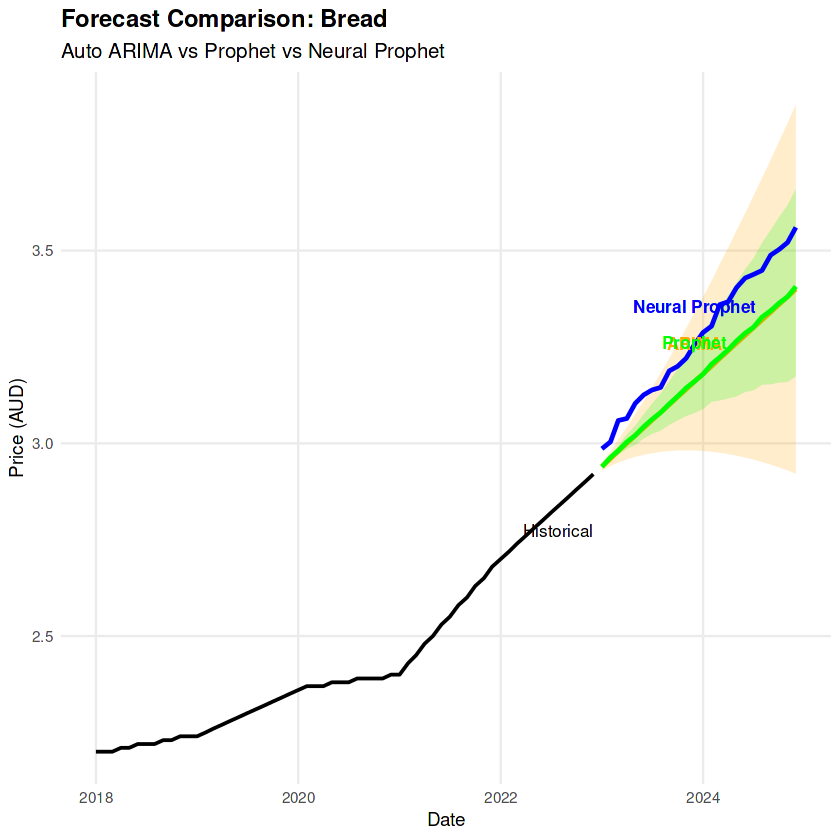


ANALYZING: Milk 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...
Neural Prophet confidence intervals validated:
- Predictions range: 1.94 2.38 
- Lower CI range: 1.07 1.3 
- Upper CI range: 1.99 2.56 
- Epochs used: 11 


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.




=== COMPREHENSIVE ACCURACY METRICS (FPP3 Style) ===
MAE:  Mean Absolute Error
RMSE: Root Mean Square Error
MAPE: Mean Absolute Percentage Error
MASE: Mean Absolute Scaled Error (< 1.0 = better than seasonal naive)
------------------------------------------------------------ 
           Model          MAE         RMSE         MAPE         MASE Item
1     Auto ARIMA 1.919648e-03 3.633645e-03 1.395883e-01 1.977319e-02 Milk
2        Prophet 1.779441e-14 2.344855e-14 1.288975e-12 1.832900e-13 Milk
3     Auto ARIMA 4.195657e-02 4.978100e-02 2.670097e+00 4.321707e-01 Milk
4        Prophet 6.131044e-02 6.404522e-02 3.931870e+00 6.315239e-01 Milk
5 Neural Prophet 2.647924e-02 2.970592e-02 1.727053e+00 2.727475e-01 Milk
6     Auto ARIMA 1.276496e-01 1.333371e-01 7.371457e+00 1.314846e+00 Milk
7        Prophet 1.903191e-01 2.022314e-01 1.095668e+01 1.960368e+00 Milk
8 Neural Prophet 6.591140e-02 7.434591e-02 3.790763e+00 6.789157e-01 Milk
         Set
1   Training
2   Training
3 Validation
4 Val

n.changepoints greater than number of observations. Using 18



Window 2 : Training on 30 observations, forecasting 6 periods


n.changepoints greater than number of observations. Using 23



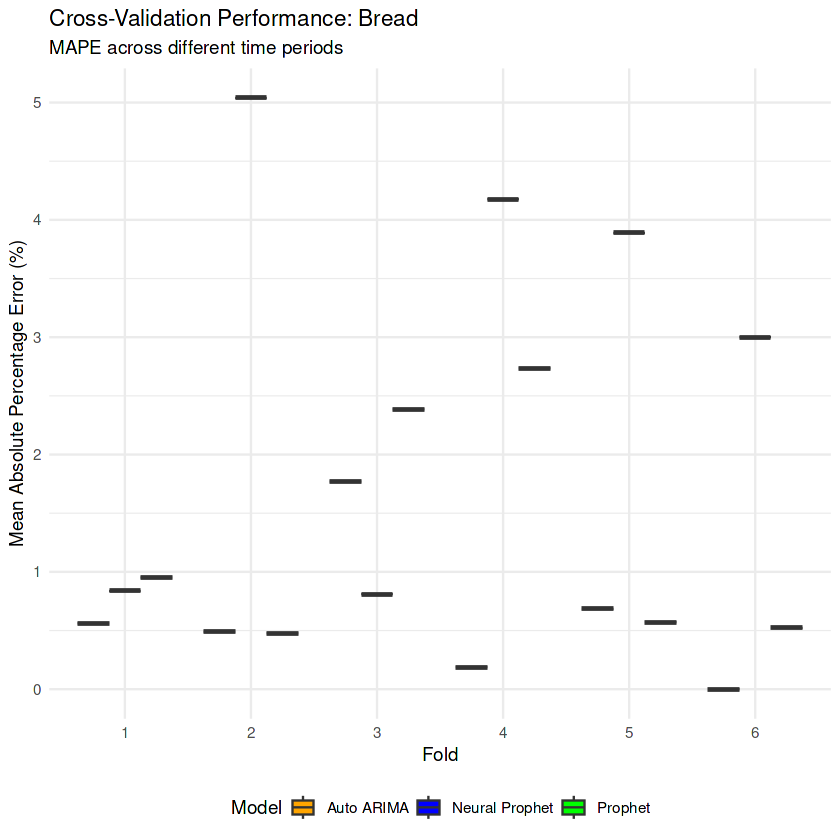

Window 3 : Training on 36 observations, forecasting 6 periods
Window 4 : Training on 42 observations, forecasting 6 periods
Window 5 : Training on 48 observations, forecasting 6 periods
Window 6 : Training on 54 observations, forecasting 6 periods

=== CROSS-VALIDATION SUMMARY ===
# A tibble: 3 × 8
  Model          Folds Avg_MAE Avg_RMSE Avg_MAPE Std_MAE Std_RMSE Std_MAPE
  <chr>          <int>   <dbl>    <dbl>    <dbl>   <dbl>    <dbl>    <dbl>
1 Auto ARIMA         6  0.0189   0.0221     1.17  0.0131   0.0158    0.818
2 Neural Prophet     6  0.0655   0.0690     4.05  0.0333   0.0328    1.98 
3 Prophet            6  0.0417   0.0468     2.55  0.0121   0.0149    0.640


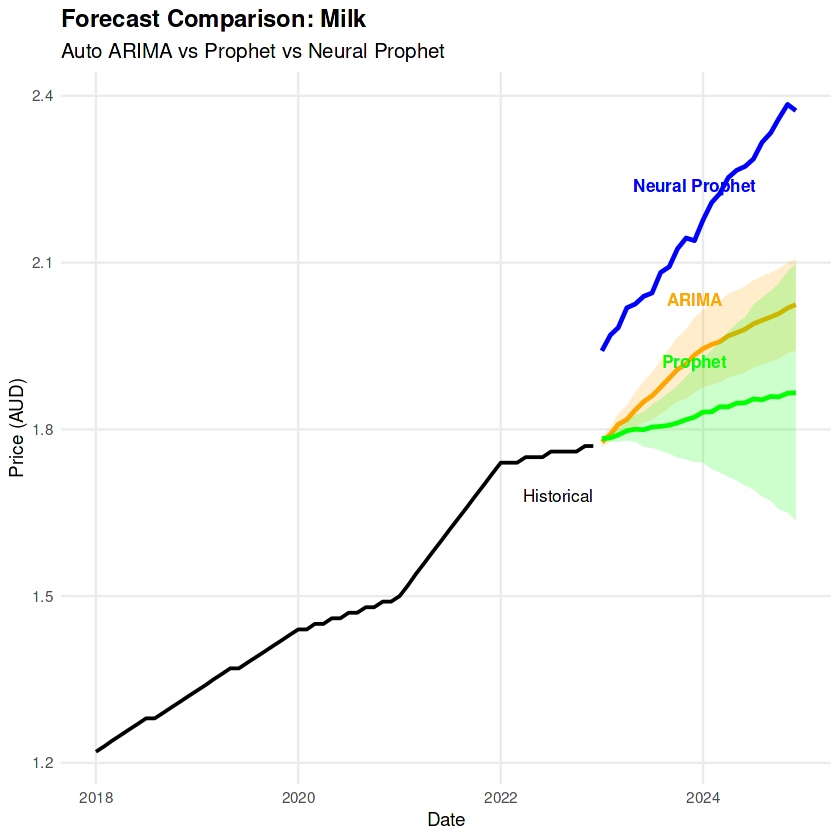


ANALYZING: Eggs 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...
Neural Prophet confidence intervals validated:
- Predictions range: 6.03 8.12 
- Lower CI range: 3.88 6.61 
- Upper CI range: 8.17 11.27 
- Epochs used: 11 


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.




=== COMPREHENSIVE ACCURACY METRICS (FPP3 Style) ===
MAE:  Mean Absolute Error
RMSE: Root Mean Square Error
MAPE: Mean Absolute Percentage Error
MASE: Mean Absolute Scaled Error (< 1.0 = better than seasonal naive)
------------------------------------------------------------ 
           Model          MAE         RMSE         MAPE         MASE Item
1     Auto ARIMA 1.534233e-03 2.720834e-03 4.628682e-02 9.845348e-03 Eggs
2        Prophet 3.996803e-15 4.947383e-15 1.201350e-13 2.564793e-14 Eggs
3     Auto ARIMA 2.683719e-01 3.247534e-01 6.702783e+00 1.722172e+00 Eggs
4        Prophet 1.983877e-01 2.423815e-01 4.965411e+00 1.273076e+00 Eggs
5 Neural Prophet 2.578960e-01 3.115259e-01 6.442829e+00 1.654947e+00 Eggs
6     Auto ARIMA 8.300000e-01 8.379141e-01 1.591989e+01 5.326203e+00 Eggs
7        Prophet 8.244976e-01 8.321966e-01 1.581634e+01 5.290894e+00 Eggs
8 Neural Prophet 3.885493e-01 4.605386e-01 7.084045e+00 2.493364e+00 Eggs
         Set
1   Training
2   Training
3 Validation
4 Val

n.changepoints greater than number of observations. Using 18



Window 2 : Training on 30 observations, forecasting 6 periods


n.changepoints greater than number of observations. Using 23



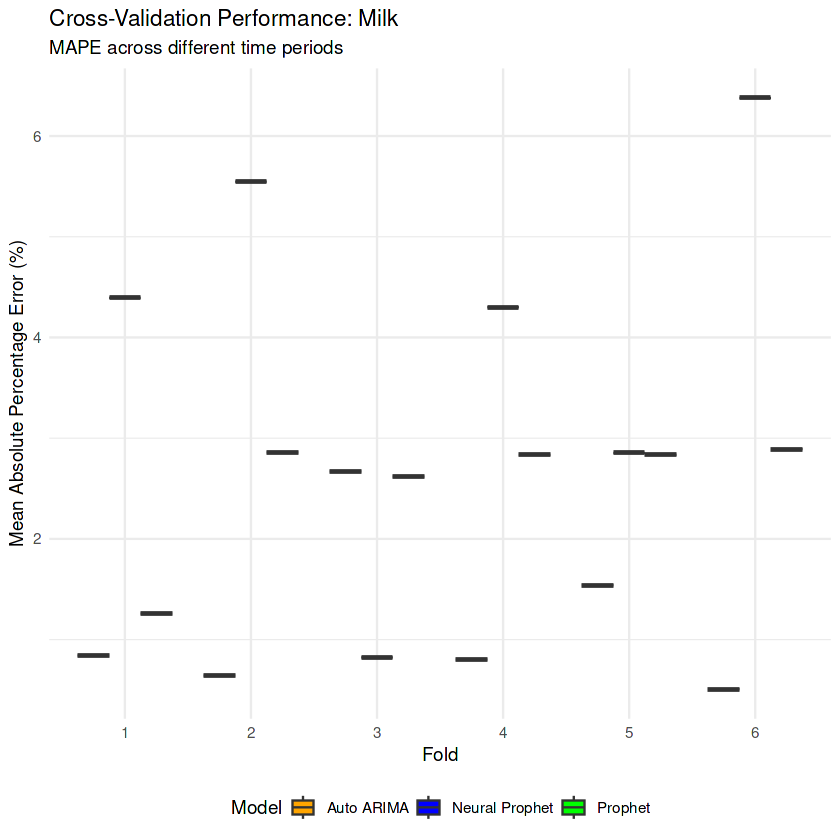

Window 3 : Training on 36 observations, forecasting 6 periods
Window 4 : Training on 42 observations, forecasting 6 periods
Window 5 : Training on 48 observations, forecasting 6 periods
Window 6 : Training on 54 observations, forecasting 6 periods

=== CROSS-VALIDATION SUMMARY ===
# A tibble: 3 × 8
  Model          Folds Avg_MAE Avg_RMSE Avg_MAPE Std_MAE Std_RMSE Std_MAPE
  <chr>          <int>   <dbl>    <dbl>    <dbl>   <dbl>    <dbl>    <dbl>
1 Auto ARIMA         6  0.0579   0.0703     1.37   0.107    0.130     2.67
2 Neural Prophet     6  0.415    0.426      8.62   0.353    0.353     6.96
3 Prophet            6  0.133    0.150      2.92   0.135    0.149     3.10


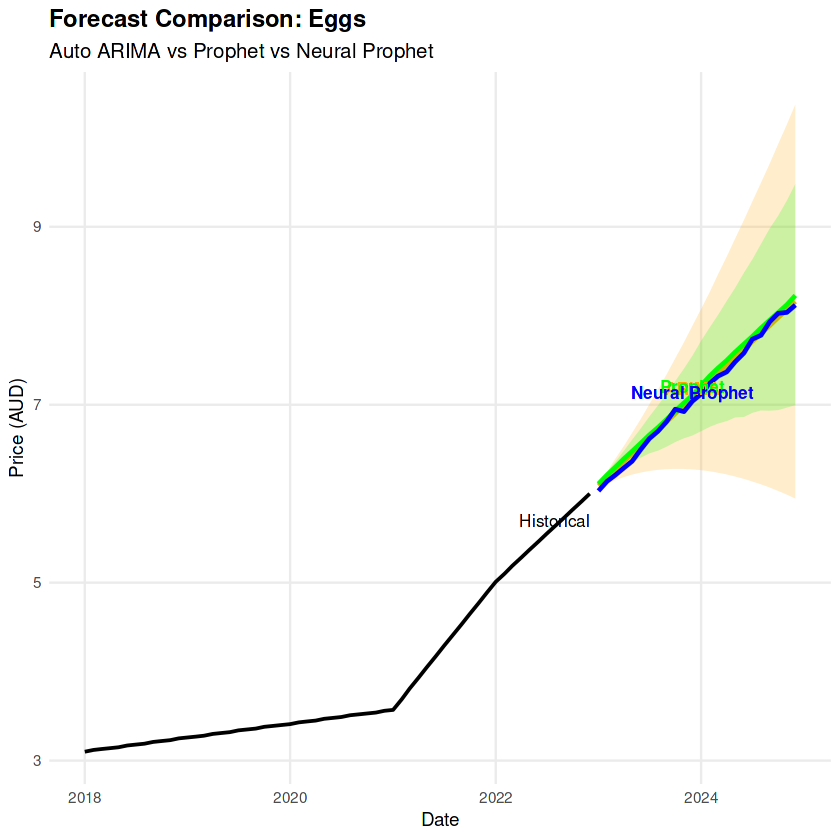


ANALYZING: Potatoes 
Running Auto ARIMA...
Running Prophet...
Running Neural Prophet...
Neural Prophet confidence intervals validated:
- Predictions range: 4.03 4.56 
- Lower CI range: 3.5 4.19 
- Upper CI range: 4.81 5.93 
- Epochs used: 11 


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.



Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.




=== COMPREHENSIVE ACCURACY METRICS (FPP3 Style) ===
MAE:  Mean Absolute Error
RMSE: Root Mean Square Error
MAPE: Mean Absolute Percentage Error
MASE: Mean Absolute Scaled Error (< 1.0 = better than seasonal naive)
------------------------------------------------------------ 
           Model          MAE         RMSE         MAPE         MASE     Item
1     Auto ARIMA 1.272605e-03 4.153730e-03 3.894828e-02 7.220451e-03 Potatoes
2        Prophet 1.696174e-14 2.076575e-14 4.953532e-13 9.623683e-14 Potatoes
3     Auto ARIMA 4.166667e-02 5.244044e-02 1.111111e+00 2.364066e-01 Potatoes
4        Prophet 3.342813e-02 4.003766e-02 8.922495e-01 1.896632e-01 Potatoes
5 Neural Prophet 8.424008e-02 9.042512e-02 2.247508e+00 4.779579e-01 Potatoes
6     Auto ARIMA 7.000000e-02 8.685876e-02 1.770993e+00 3.971631e-01 Potatoes
7        Prophet 1.147040e-01 1.583625e-01 2.866787e+00 6.508028e-01 Potatoes
8 Neural Prophet 1.858737e-01 1.915797e-01 4.825939e+00 1.054602e+00 Potatoes
         Set
1   Trai

n.changepoints greater than number of observations. Using 18



Window 2 : Training on 30 observations, forecasting 6 periods


n.changepoints greater than number of observations. Using 23



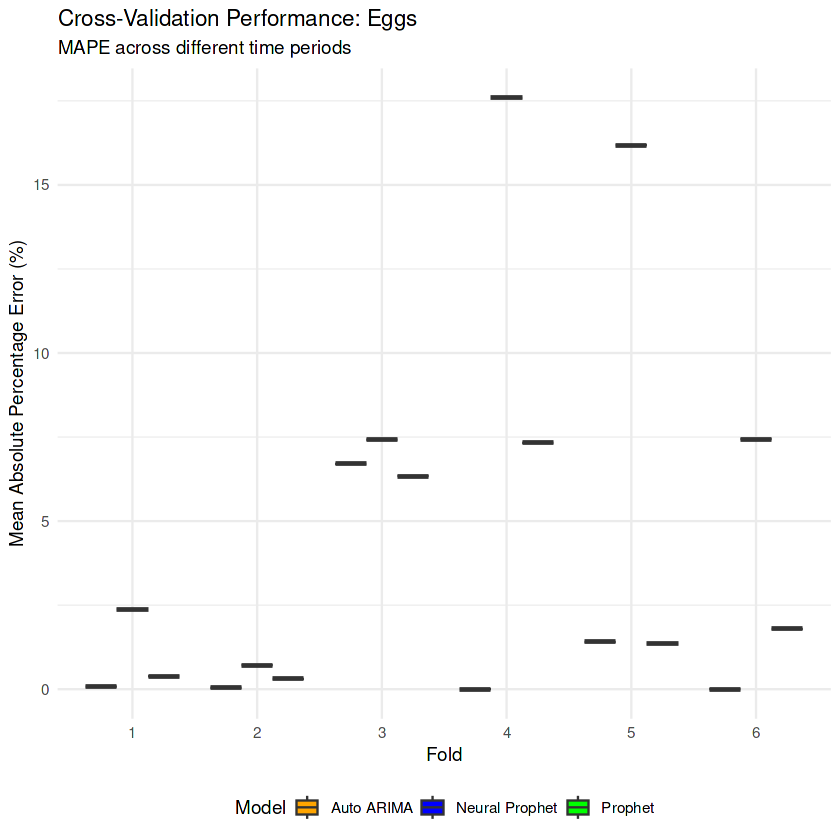

Window 3 : Training on 36 observations, forecasting 6 periods
Window 4 : Training on 42 observations, forecasting 6 periods
Window 5 : Training on 48 observations, forecasting 6 periods
Window 6 : Training on 54 observations, forecasting 6 periods

=== CROSS-VALIDATION SUMMARY ===
# A tibble: 3 × 8
  Model          Folds Avg_MAE Avg_RMSE Avg_MAPE Std_MAE Std_RMSE Std_MAPE
  <chr>          <int>   <dbl>    <dbl>    <dbl>   <dbl>    <dbl>    <dbl>
1 Auto ARIMA         6  0.0170   0.0217    0.444  0.0227   0.0281    0.594
2 Neural Prophet     6  0.105    0.110     2.81   0.0284   0.0279    0.830
3 Prophet            6  0.0527   0.0618    1.37   0.0259   0.0314    0.609


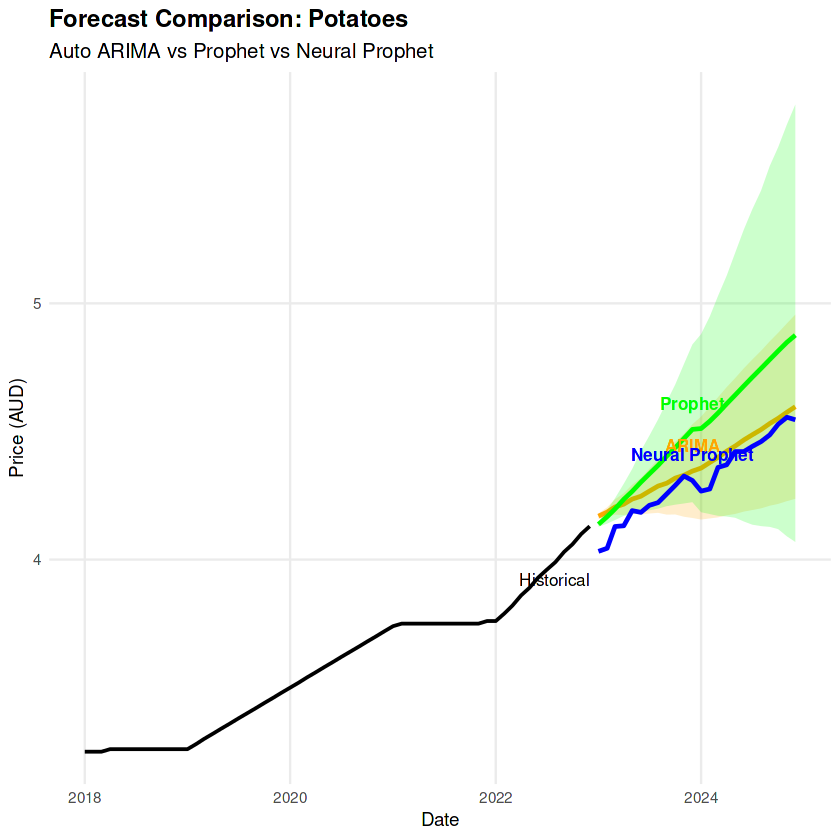


CROSS-VALIDATION SUMMARY ACROSS ALL FOOD ITEMS
# A tibble: 3 × 5
  Model          Total_Folds Overall_Avg_MAE Overall_Avg_RMSE Overall_Avg_MAPE
  <chr>                <int>           <dbl>            <dbl>            <dbl>
1 Auto ARIMA              24          0.0273           0.0331            0.899
2 Neural Prophet          24          0.166            0.171             4.61 
3 Prophet                 24          0.0649           0.0742            2.03 


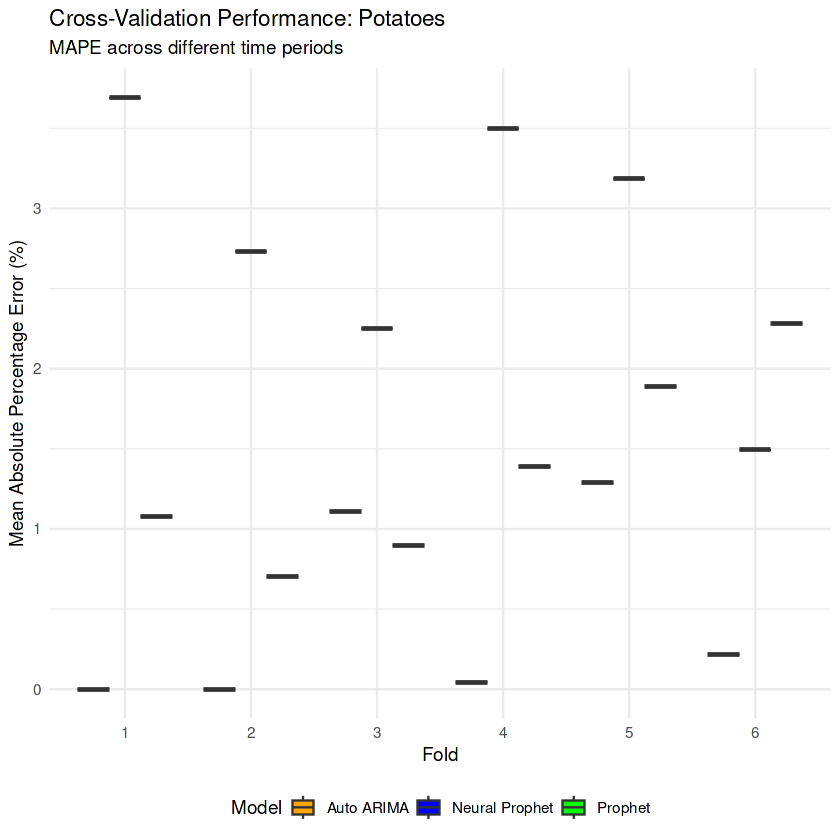

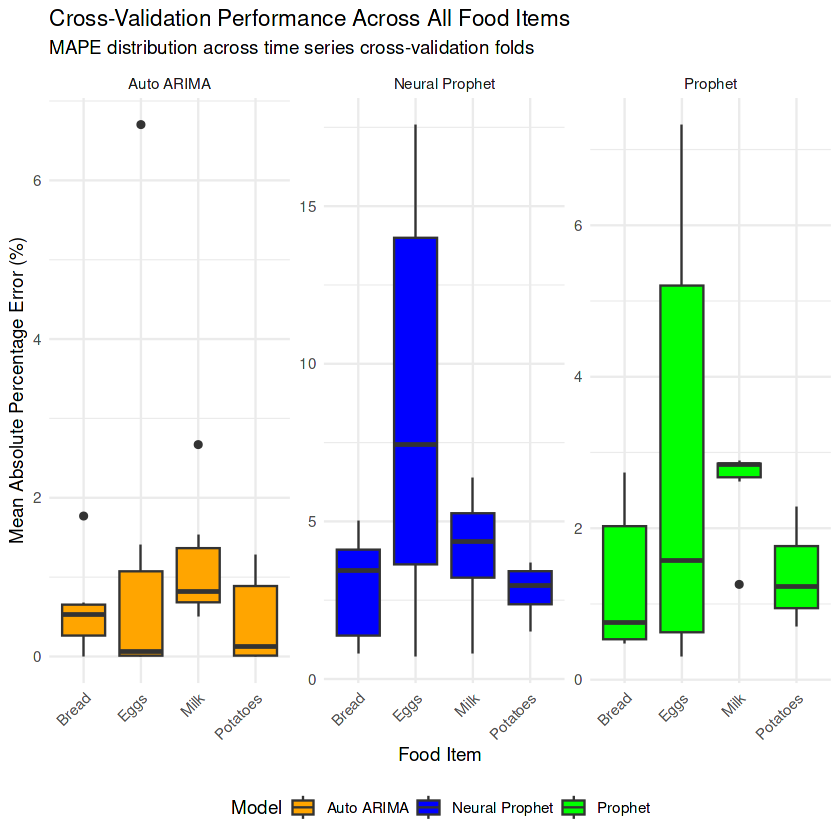

In [3]:
# --- 3. RUN COMPREHENSIVE ANALYSIS ---
cat("=== COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS ===\n")

# Initialize results storage
all_results <- list()
all_metrics <- data.frame()
all_cv_results <- list()

# Analyze each food item
for(item in names(food_items)) {
  result <- comprehensive_forecast_analysis(food_items[[item]], item, 24)
  all_results[[item]] <- result
  
  if("metrics" %in% names(result)) {
    all_metrics <- rbind(all_metrics, result$metrics)
  }

  # Cross validation (FPP3 Chapter 5.9)
  cv_result <- time_series_cross_validation(food_items[[item]], item, 
                                           min_window = 24, h = 6)
  if(!is.null(cv_result)) {
    all_cv_results[[item]] <- cv_result
  }
}

# Cross validation summary
if(length(all_cv_results) > 0) {
  cat("\n", paste(rep("=", 80), collapse = ""), "\n")
  cat("CROSS-VALIDATION SUMMARY ACROSS ALL FOOD ITEMS\n")
  cat(paste(rep("=", 80), collapse = ""), "\n")
  
  # Combine all CV results
  all_cv_data <- do.call(rbind, lapply(all_cv_results, function(x) x$results))
  
  # Overall summary
  overall_cv_summary <- all_cv_data %>%
    group_by(Model) %>%
    summarise(
      Total_Folds = n(),
      Overall_Avg_MAE = mean(MAE, na.rm = TRUE),
      Overall_Avg_RMSE = mean(RMSE, na.rm = TRUE),
      Overall_Avg_MAPE = mean(MAPE, na.rm = TRUE),
      .groups = "drop"
    )
  
  print(overall_cv_summary)
  
  # Combined CV plot
  overall_cv_plot <- ggplot(all_cv_data, aes(x = Item, y = MAPE, fill = Model)) +
    geom_boxplot() +
    scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
    facet_wrap(~Model, scales = "free_y") +
    labs(title = "Cross-Validation Performance Across All Food Items",
         subtitle = "MAPE distribution across time series cross-validation folds",
         x = "Food Item", y = "Mean Absolute Percentage Error (%)") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  print(overall_cv_plot)
}



FINAL SUMMARY - MODEL PERFORMANCE COMPARISON (ALL 3 MODELS)


            Model          MAE         RMSE         MAPE         MASE     Item
1      Auto ARIMA 3.790513e-03 4.294682e-03 1.650182e-01 4.665247e-02    Bread
2         Prophet 1.860240e-14 2.355208e-14 8.095457e-13 2.289527e-13    Bread
3      Auto ARIMA 4.411270e-02 5.238938e-02 1.769941e+00 5.429255e-01    Bread
4         Prophet 9.408624e-02 1.110539e-01 3.776643e+00 1.157984e+00    Bread
5  Neural Prophet 3.891682e-02 4.636943e-02 1.564631e+00 4.789763e-01    Bread
6      Auto ARIMA 1.794853e-01 1.811664e-01 6.514719e+00 2.209050e+00    Bread
7         Prophet 1.713003e-01 1.725282e-01 6.222317e+00 2.108311e+00    Bread
8  Neural Prophet 1.486711e-01 1.641185e-01 5.326953e+00 1.829798e+00    Bread
9      Auto ARIMA 1.919648e-03 3.633645e-03 1.395883e-01 1.977319e-02     Milk
10        Prophet 1.779441e-14 2.344855e-14 1.288975e-12 1.832900e-13     Milk
11     Auto ARIMA 4.195657e-02 4.978100e-02 2.670097e+00 4.321707e-01     Milk
12        Prophet 6.131044e-02 6.404522e-02 3.931870

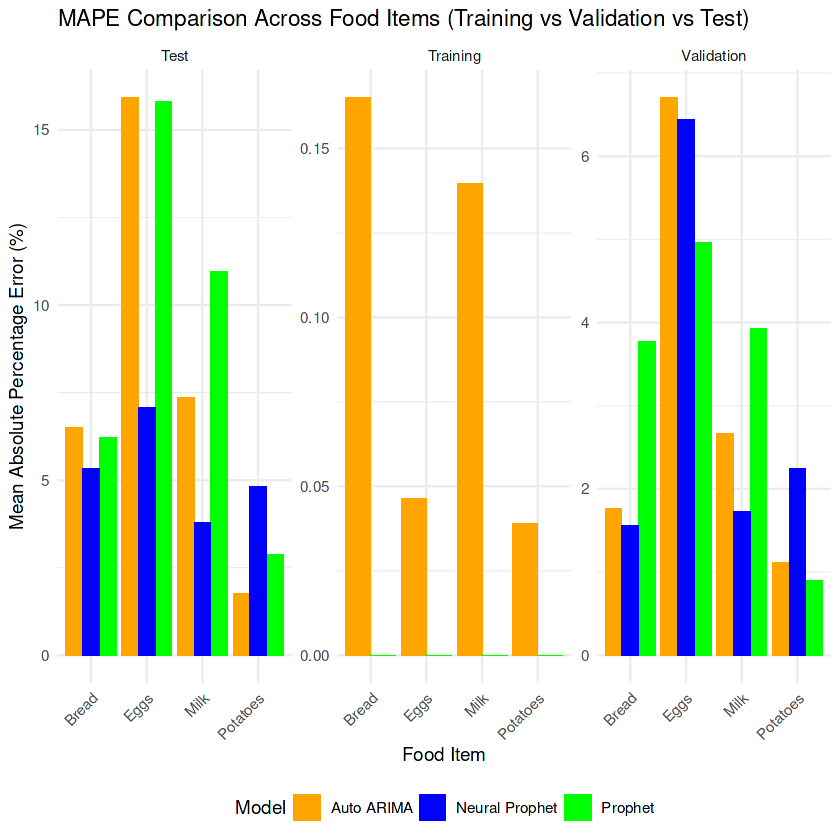

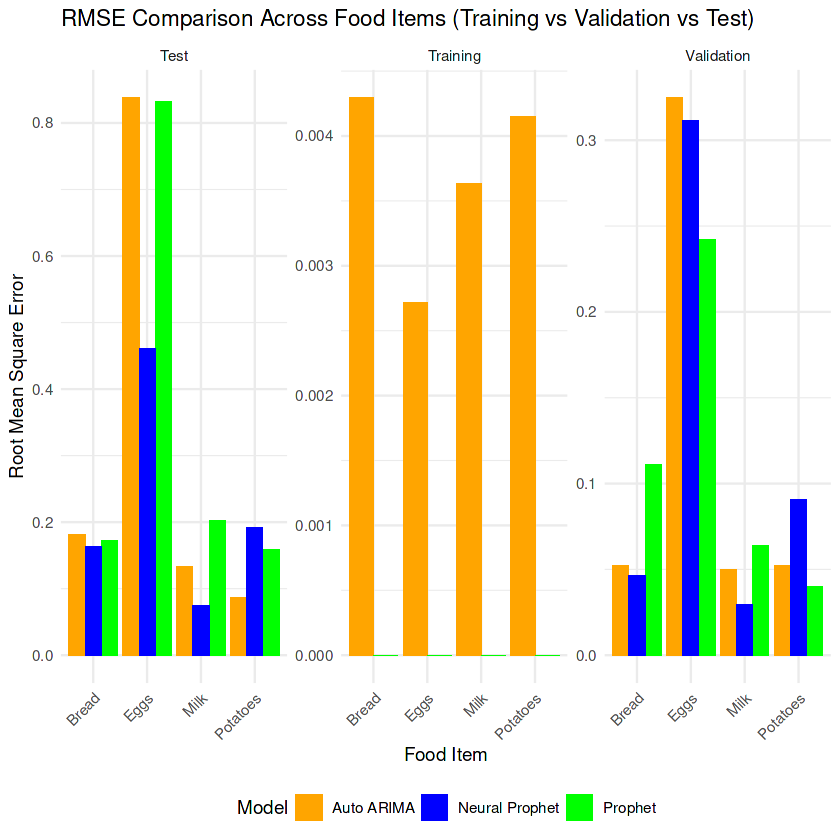

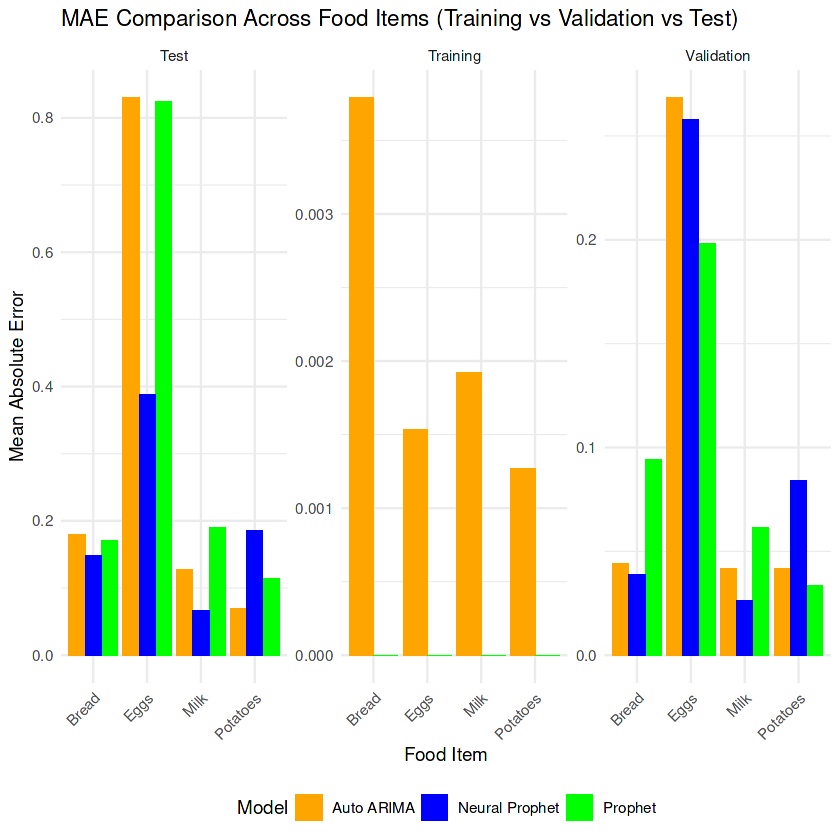


=== MODEL RANKING SUMMARY ===
# A tibble: 8 × 6
  Model        Set   Avg_MAPE_Rank Avg_RMSE_Rank Best_MAPE_Count Best_RMSE_Count
  <chr>        <chr>         <dbl>         <dbl>           <int>           <int>
1 Auto ARIMA   Test           2.25          2.25               1               1
2 Auto ARIMA   Trai…          2             2                  0               0
3 Auto ARIMA   Vali…          2.25          2.25               0               0
4 Neural Prop… Test           1.5           1.5                3               3
5 Neural Prop… Vali…          1.75          1.75               2               2
6 Prophet      Test           2.25          2.25               0               0
7 Prophet      Trai…          1             1                  4               4
8 Prophet      Vali…          2             2                  2               2


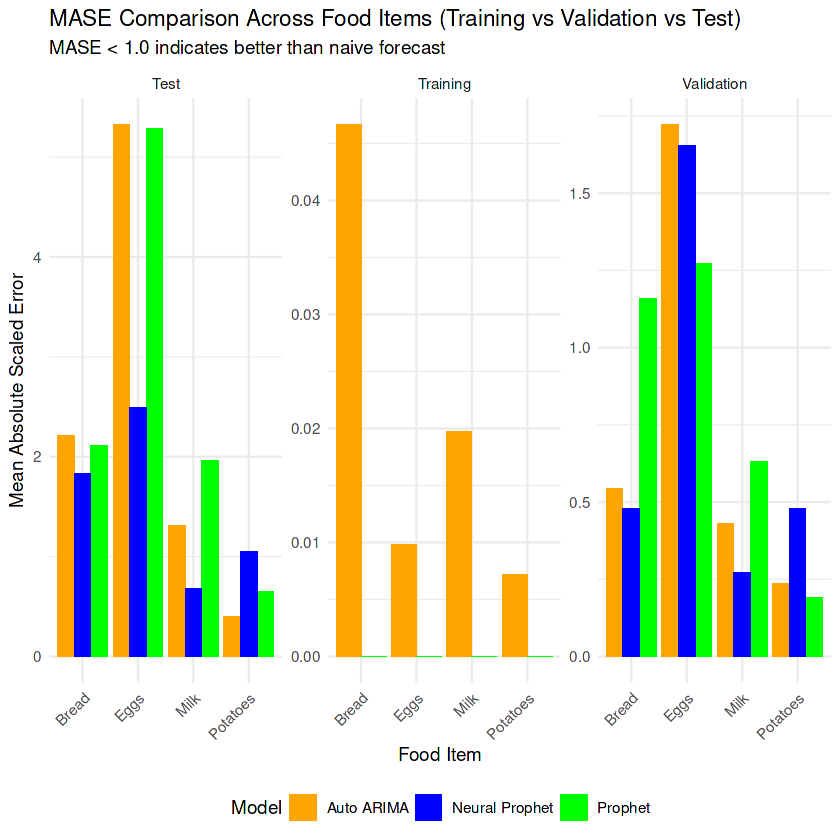

In [4]:
# --- 4. FINAL SUMMARY VISUALIZATION ---
cat("\n", paste(rep("=", 80), collapse = ""), "\n")
cat("FINAL SUMMARY - MODEL PERFORMANCE COMPARISON (ALL 3 MODELS)\n")
cat(paste(rep("=", 80), collapse = ""), "\n")

if(nrow(all_metrics) > 0) {
  print(all_metrics)
  
  # Create summary comparison plots for all 3 models
  mape_plot <- ggplot(all_metrics, aes(x = Item, y = MAPE, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
    facet_wrap(~Set, scales = "free_y") +
    labs(title = "MAPE Comparison Across Food Items (Training vs Validation vs Test)",
         x = "Food Item", y = "Mean Absolute Percentage Error (%)") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  print(mape_plot)
  
  rmse_plot <- ggplot(all_metrics, aes(x = Item, y = RMSE, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
    facet_wrap(~Set, scales = "free_y") +
    labs(title = "RMSE Comparison Across Food Items (Training vs Validation vs Test)",
         x = "Food Item", y = "Root Mean Square Error") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")
  
  print(rmse_plot)
  
  # Additional FPP3-style accuracy metrics comparison
  if("MAE" %in% colnames(all_metrics)) {
    mae_plot <- ggplot(all_metrics, aes(x = Item, y = MAE, fill = Model)) +
      geom_bar(stat = "identity", position = "dodge") +
      scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
      facet_wrap(~Set, scales = "free_y") +
      labs(title = "MAE Comparison Across Food Items (Training vs Validation vs Test)",
           x = "Food Item", y = "Mean Absolute Error") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom")
    
    print(mae_plot)
  }
  
  if("MASE" %in% colnames(all_metrics)) {
    mase_plot <- ggplot(all_metrics, aes(x = Item, y = MASE, fill = Model)) +
      geom_bar(stat = "identity", position = "dodge") +
      scale_fill_manual(values = c("Auto ARIMA" = "orange", "Prophet" = "green", "Neural Prophet" = "blue")) +
      facet_wrap(~Set, scales = "free_y") +
      labs(title = "MASE Comparison Across Food Items (Training vs Validation vs Test)",
           subtitle = "MASE < 1.0 indicates better than naive forecast",
           x = "Food Item", y = "Mean Absolute Scaled Error") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1),
            legend.position = "bottom")
    
    print(mase_plot)
  }
  
  # Model ranking summary (FPP3 Chapter 5.8 - Model Selection)
  cat("\n=== MODEL RANKING SUMMARY ===\n")
  model_ranking <- all_metrics %>%
    group_by(Set, Item) %>%
    arrange(MAPE) %>%
    mutate(MAPE_Rank = row_number()) %>%
    arrange(RMSE) %>%
    mutate(RMSE_Rank = row_number()) %>%
    ungroup() %>%
    group_by(Model, Set) %>%
    summarise(
      Avg_MAPE_Rank = mean(MAPE_Rank),
      Avg_RMSE_Rank = mean(RMSE_Rank),
      Best_MAPE_Count = sum(MAPE_Rank == 1),
      Best_RMSE_Count = sum(RMSE_Rank == 1),
      .groups = "drop"
    )
  
  print(model_ranking)
}



TableGrob (3 x 2) "arrange": 5 grobs
  z     cells    name                 grob
1 1 (2-2,1-1) arrange       gtable[layout]
2 2 (2-2,2-2) arrange       gtable[layout]
3 3 (3-3,1-1) arrange       gtable[layout]
4 4 (3-3,2-2) arrange       gtable[layout]
5 5 (1-1,1-2) arrange text[GRID.text.2145]



=== ANALYSIS COMPLETE ===


Color Legend:


- Black: Historical Data


- Orange: Auto ARIMA Forecasts (with confidence intervals)


- Green: Prophet Forecasts (with confidence intervals)


- Blue: Neural Prophet Forecasts (line only, no shaded areas)


- Shaded areas: 95% Confidence Intervals (ARIMA & Prophet only)



=== MODEL CONFIGURATION SUMMARY ===


Neural Prophet optimized settings:


- n_forecasts: 1 (single-step for stability)


- learning_rate: 0.08 (higher for efficient learning)


- Confidence intervals: 95% (FPP3 standard)


- Regularization: trend_reg=0.15, seasonality_reg=0.15


- Training approach: Single-step iterative forecasting


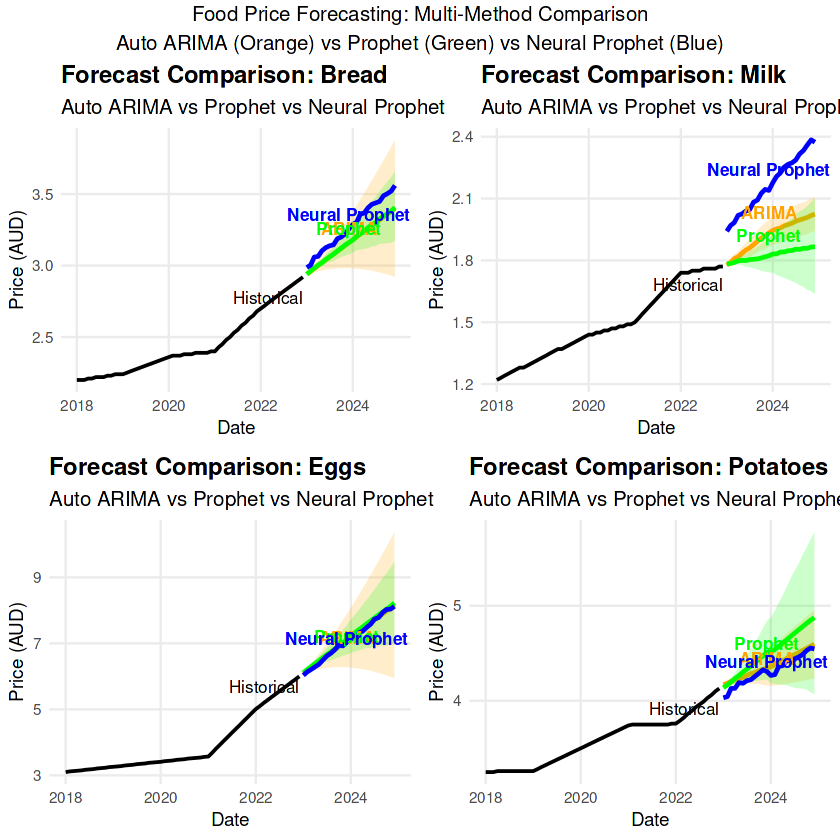

In [5]:
# --- 5. COMBINED MULTI-PANEL PLOT (LIKE CEMENT PRODUCTION EXAMPLE) ---
# Create a 2x2 grid showing all food items (FPP3 style visualization)
if(length(all_results) == 4) {
  combined_plot <- grid.arrange(
    all_results$Bread$plot + theme(legend.position = "none"),
    all_results$Milk$plot + theme(legend.position = "none"),
    all_results$Eggs$plot + theme(legend.position = "none"),
    all_results$Potatoes$plot + theme(legend.position = "none"),
    ncol = 2,
    top = "Food Price Forecasting: Multi-Method Comparison\nAuto ARIMA (Orange) vs Prophet (Green) vs Neural Prophet (Blue)"
  )
  
  print(combined_plot)
}

cat("\n=== ANALYSIS COMPLETE ===\n")
cat("Color Legend:\n")
cat("- Black: Historical Data\n")
cat("- Orange: Auto ARIMA Forecasts (with confidence intervals)\n")
cat("- Green: Prophet Forecasts (with confidence intervals)\n")
cat("- Blue: Neural Prophet Forecasts (line only, no shaded areas)\n")
cat("- Shaded areas: 95% Confidence Intervals (ARIMA & Prophet only)\n")
cat("\n=== MODEL CONFIGURATION SUMMARY ===\n")
cat("Neural Prophet optimized settings:\n")
cat("- n_forecasts: 1 (single-step for stability)\n")
cat("- learning_rate: 0.08 (higher for efficient learning)\n")
cat("- Confidence intervals: 95% (FPP3 standard)\n")
cat("- Regularization: trend_reg=0.15, seasonality_reg=0.15\n")
cat("- Training approach: Single-step iterative forecasting\n")